In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import coolname
from third_party.gmm_torch.gmm import GaussianMixture
from card_1_lib import wolf_dens, plot_distribution

### In this notebook we're going to be dealing with information sharing, so we will need a better definition of our explorer agents

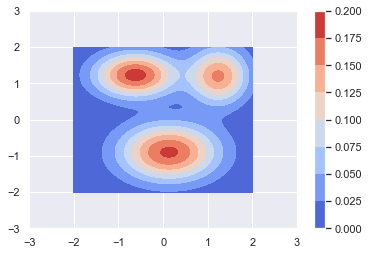

In [2]:
class Explorer:
    """
    A class used to represent our explorers. 
    Attributes:
    environment : GaussianMixture
        The environment the explorer samples from
    model : GaussianMixture
        The internal model the explorer has of its environment
    experiences : Tensor
        A buffer containing samples from the environment.
    name : string
        The explorer's name
    """
    def __init__(
        self,
        environment: GaussianMixture = wolf_dens,
        model: GaussianMixture = None,
    ) -> None:
        """Initializes the explorer with a given environment and internal model"""
        self.environment = environment
        self.model = model
        self.experiences = torch.empty(0, 2)
        self.notes = {}
        self.name = coolname.generate_slug(3)
    
    def sample(self, n: int) -> None:
        """Draws n samples from the environment, and adds them to experience buffer"""
        samples, _ = self.environment.sample(n)
        self.experiences = torch.cat([self.experiences, samples])
    
    def fit(self, samples) -> None:
        """Fits internal model to experiences"""
        self.model = GaussianMixture(n_components=3, n_features=2, covariance_type="diag")
        self.model.fit(samples)
    
    def display(self, show=True, **kwargs) -> None:
        """Displays GMM"""
        plot_distribution(self.model, **kwargs)
        if show:
            plt.xlim([-3, 3])
            plt.ylim([-3, 3])
            plt.show()

    def believed_locations(self) -> torch.tensor:
        """Displays all believed wolf locations, experienced and in notes"""
        return torch.cat([self.experiences] + [note for note in self.notes.values()])

    def __repr__(self) -> str:
        return self.name


explorer_1 = Explorer()
explorer_1.sample(100)
explorer_1.fit(explorer_1.experiences)
explorer_1.display()

Lets say we have 5 explorers, and each day they each spot 3 wolves a day. This is what their states of the world will look like over time.

In [3]:
n_explorers = 4
wolves_per_day = 10
days = 5

Estimates after day 1.


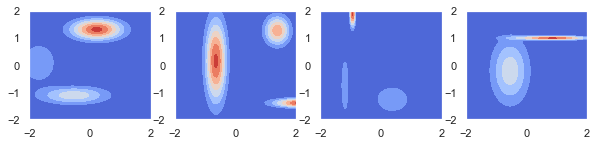

Estimates after day 2.


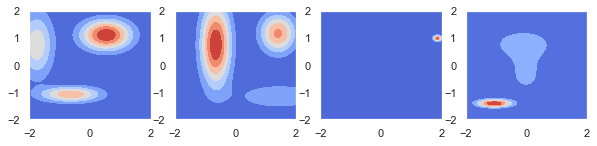

Estimates after day 3.


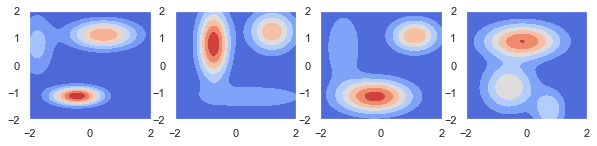

Estimates after day 4.


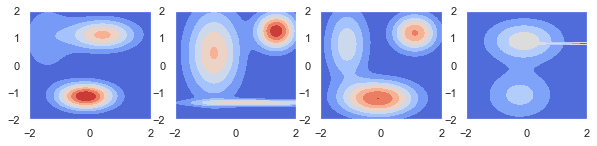

Estimates after day 5.


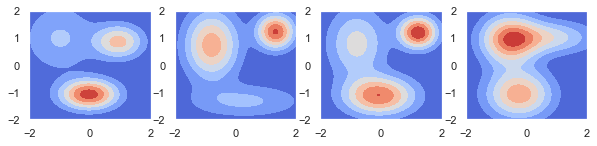

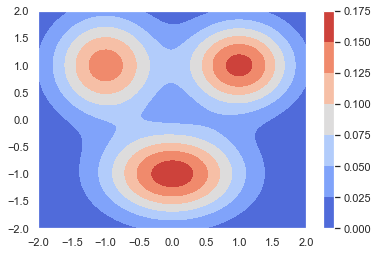

In [4]:
explorers = [Explorer() for _ in range(n_explorers)]
for day in range(days):

    fig, axs = plt.subplots(1, n_explorers)
    fig.set_size_inches(10, 2)
    for explorer, ax in zip(explorers, axs):
        explorer.sample(wolves_per_day)
        explorer.fit(explorer.experiences)
        explorer.display(show=False, ax=ax, cbar=False, title=False)
    print(f"Estimates after day {day + 1}.")
    plt.show()
plot_distribution(wolf_dens)

In the above example, each explorer bases its model on the wolves that explorer personally saw. Naturally, our explorers could learn faster if they shared notes. 

Explorers will leave notes for one another as they explore, each day an explorer will have a 50% chance of finding another explorer's notes, containing their wolf locations. 

Estimates after day 1.


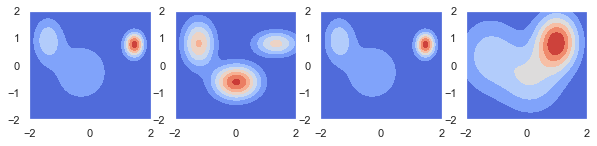

Estimates after day 2.


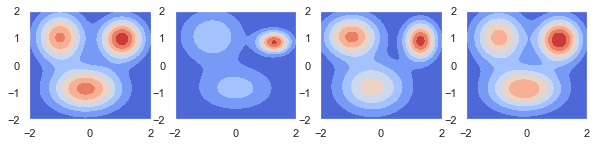

Estimates after day 3.


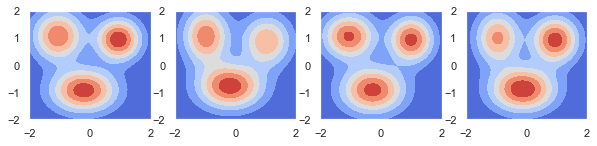

Estimates after day 4.


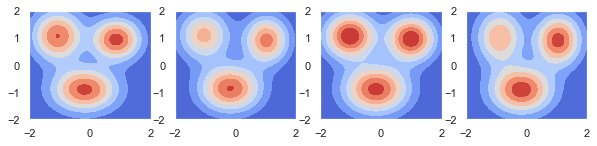

Estimates after day 5.


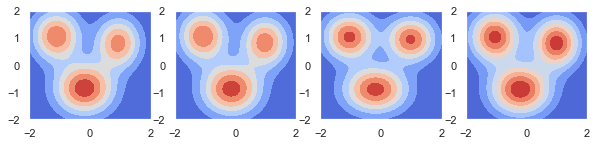

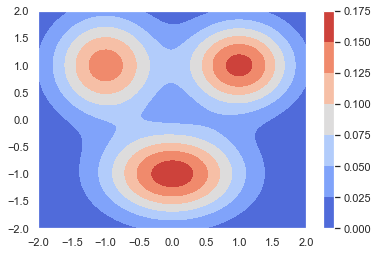

In [5]:
from random import random
read_prob = 0.5

explorers = [Explorer() for _ in range(n_explorers)]

for day in range(days):
    for explorer in explorers:
        explorer.sample(wolves_per_day)
    fig, axs = plt.subplots(1, n_explorers)
    fig.set_size_inches(10, 2)
    for explorer, ax in zip(explorers, axs):
        for other in explorers:
            if other != explorer and random() < read_prob:
                explorer.notes[other.name] = other.experiences.clone()
        explorer.fit(explorer.believed_locations())
        explorer.display(show=False, ax=ax, cbar=False, title=False)

    print(f"Estimates after day {day + 1}.")
    plt.show()

plot_distribution(wolf_dens)